In [ ]:
# import os
# torch.cuda.empty_cache()
# os._exit(00)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset
import random
from transformers import AutoTokenizer, RobertaModel

D:\bioinfo\interpreters\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = RobertaModel.from_pretrained("DeepChem/ChemBERTa-77M-MTR", device_map='auto')
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Установите сид
set_seed(23)

D:\bioinfo\interpreters\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--DeepChem--ChemBERTa-77M-MTR. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ImportError: Using `low_cpu_mem_usage=True` or a `device_map` requires Accelerate: `pip install 'accelerate>=0.26.0'`

In [3]:
data = pd.read_csv("chembl253_final.csv")

In [4]:
data.head()

,ki,id,smiles
0,630.96,CHEMBL1828806,CCCCCn1cc(C(=O)Nc2ccc3ccccc3c2)c2ccccc21
1,1000.00,CHEMBL157591,C/N=C(\NS(=O)(=O)c1cccc(C(F)(F)F)c1)N1CC(c2ccc...
2,1000.00,CHEMBL583855,CCc1c(C(=O)NN2CCCCC2)nc(-c2ccccc2Cl)n1-c1ccc(C...
3,1578.00,CHEMBL590481,CC(C)CNC(=O)[C@@H]1CC[C@@H](c2ccc(Cl)cc2Cl)N(c...
4,7.80,CHEMBL2348469,CC1(C)Oc2cc(C34CC5CC(CC(C5)C3)C4)cc(O)c2[C@@H]...


In [5]:
class SmilesDataset(Dataset):
    def __init__(self, smiles):
        self.smiles = smiles
        self.tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
    
    def __len__(self):
        return len(self.smiles)
    
    def __getitem__(self, idx):
        smiles = self.smiles[idx]
        inputs = self.tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        return inputs

In [6]:
def collate_fn(batch):
    input_ids = [item.get("input_ids").squeeze(0) for item in batch]
    attention_mask = [item.get("attention_mask").squeeze(0) for item in batch]

    input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=dataset.tokenizer.pad_token_id)
    attention_mask_padded = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    return input_ids_padded, attention_mask_padded

In [7]:
smiles = data["smiles"].tolist()
dataset = SmilesDataset(smiles)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True, collate_fn=collate_fn)

In [8]:
all_outputs = []
for input_ids, attention_mask in dataloader:
    inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
    with torch.no_grad():
        outputs = model(**inputs)
    all_outputs.append(outputs.last_hidden_state)
    

In [9]:
all_outputs[0].shape

torch.Size([32, 75, 384])

In [10]:
max_length = max([output.size(1) for output in all_outputs])

padded_outputs = [torch.nn.functional.pad(output, (0, 0, 0, max_length - output.size(1))) for output in all_outputs]

combined_outputs = torch.cat(padded_outputs, dim=0)

In [11]:
# idx=0
# for i in combined_outputs:
#     if combined_outputs[idx][155][1] != 0.0:
#         print(idx)
#     idx+=1

In [12]:
combined_outputs.shape

torch.Size([5394, 156, 384])

In [13]:
tensor_np = combined_outputs[0].numpy()

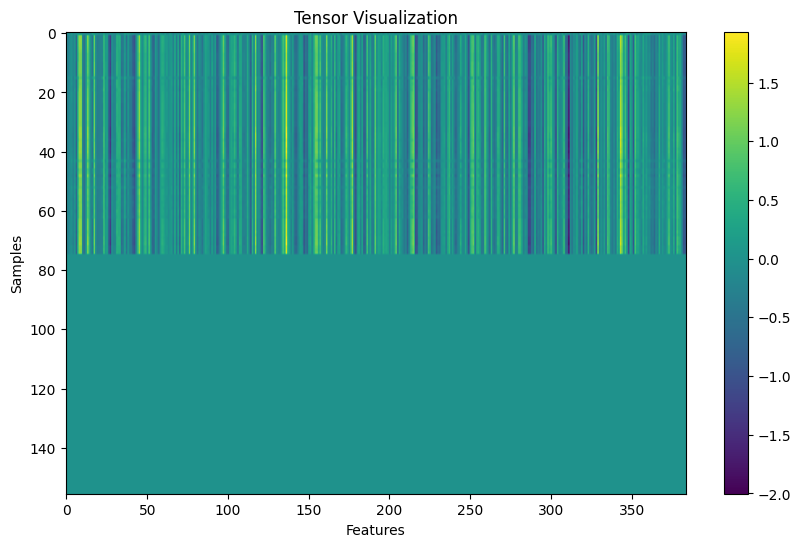

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(tensor_np, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Tensor Visualization')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

In [15]:
X= combined_outputs.numpy()

In [16]:
X_flat = X.reshape(X.shape[0], -1)
print(X_flat.shape) 

(5394, 59904)


In [17]:
y= data['ki']

In [18]:
y.shape

(5394,)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [20]:
min_max = MinMaxScaler().fit(y.to_numpy().reshape(-1,1))
y_norm = min_max.transform(y.to_numpy().reshape(-1,1))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_norm, test_size=0.2, random_state=23)

In [22]:
# from sklearn.linear_model import LinearRegression
# lr = LinearRegression().fit(X_train, y_train)

In [23]:
# y_pred = lr.predict(X_test)

In [24]:
# mse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f'Root Mean Squared Error: {mse}')
# mse > 8.

In [25]:
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.tree import DecisionTreeRegressor
# dt_regressor = DecisionTreeRegressor(random_state=23)
# ada_boost = AdaBoostRegressor(random_state=23, n_estimators=100, loss='linear', estimator=dt_regressor)
# ada_boost.fit(X_train, y_train.ravel())

In [26]:
# y_pred = ada_boost.predict(X_test)
# mse = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f'Root Mean Squared Error: {mse}')


In [27]:
from sklearn.svm import SVR
svr = SVR(kernel="linear", C=1, epsilon=0.1)
svr.fit(X_train, y_train.ravel())


SVR(C=1, kernel='linear')

In [28]:
y_pred = svr.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {mse}')

Root Mean Squared Error: 0.21909761799885863


In [31]:
from sklearn.svm import SVR
svr = SVR(kernel="rbf", C=0.5, epsilon=0.1)
svr.fit(X_train, y_train.ravel())

SVR(C=0.5)

In [32]:
y_pred = svr.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {mse}')

Root Mean Squared Error: 0.15244492903095516


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create the custom scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [32]:
# import os

# os.environ["TOKENIZERS_PARALLELISM"] = "false"



# param_grid = {
#     'C': [0.1, 1, 10, 100, 1000],       # Regularization parameter
#     'epsilon': [0.1, 0.2, 0.5, 0.3, 0.05, 0.01, 0.001], # Epsilon in the epsilon-SVR model
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # Kernel type
#     'gamma': ['scale', 'auto'],         # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
#     'degree': [2, 3, 4, 5],             # Degree of the polynomial kernel function ('poly')
#     'coef0': [0.0, 0.1, 0.5, 1.0]       # Independent term in kernel function ('poly' and 'sigmoid')
# }

# grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=10, n_jobs=1, verbose=2, scoring=rmse_scorer)

In [ ]:
# grid_search.fit(X_train, y_train.ravel())

Fitting 10 folds for each of 4480 candidates, totalling 44800 fits


In [12]:
import grid_search
from sklearn.svm import SVR

svr = SVR()
grid_search.start_train(rmse_scorer, svr, X_train, y_train)

Fitting 5 folds for each of 4480 candidates, totalling 22400 fits
[CV] END C=0.1, coef0=0.0, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, coef0=0.0, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, coef0=0.0, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, coef0=0.0, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, coef0=0.0, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END C=0.1, coef0=0.0, degree=2, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, coef0=0.0, degree=2, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, coef0=0.0, degree=2, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, coef0=0.0, degree=2, epsilon=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END C=0.1, coef0=0.0, degree=2, epsilon=0.1, gamma=scale, kernel

ValueError: 
All the 22400 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
22400 fits failed with the following error:
Traceback (most recent call last):
  File "/home/matikmate/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/matikmate/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/matikmate/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/svm/_base.py", line 190, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/matikmate/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/matikmate/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/home/matikmate/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py", line 957, in check_array
    _assert_all_finite(
  File "/home/matikmate/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py", line 122, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/home/matikmate/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/utils/validation.py", line 171, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
SVR does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [13]:
grid_search.save_parameters_as_file()